In [2]:
import numpy as np
import cupy as cp
import imageio

import scipy.io
import matplotlib as mpl
from matplotlib import pyplot as plt

import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

import yaml
import os
import cv2

import itertools
import cv2
import scipy
from scipy import misc
from PIL import Image

import math
from skimage.filters import threshold_otsu


We first define some basic constants.

In [3]:
# the number of radians per rotation.
RADIANS_PER_ROTATION = 2 * np.pi

## Defining the Space

We consider a particle on a random walk over $[0, h) \times [0, w)$, where $h$ and $w$ denote the height and width of the space, respectively.

At any given moment in time, the state of the walk is defined by the particle's spatial-position, $(y,x) \in [0, h) \times [0, w)$ and its orientation, $\theta \in [0, 2\pi)$.

The state evolves according to the following set of differential equations,
$$\begin{aligned}
\dot{y} &= \sin{\theta} \\
\dot{x} &= \cos{\theta} \\
\dot{\theta} &\sim \mathcal{N}(0, \sigma^2; t)
\end{aligned}$$

In general, we observe that
$$ \frac{\partial P}{\partial t} = \frac{\partial x}{\partial t}\frac{\partial P}{\partial x} + \frac{\partial y}{\partial t}\frac{\partial P}{\partial y} + \frac{\partial \theta}{\partial t}\frac{\partial P}{\partial \theta}$$

In [4]:
# the diffusivity of the random-walk.
SIGMA_SQRT = np.sqrt(0.01)

# the half-life of the particle.
TAU = 80

w = 256
h = 256

## Discretizing the Points

Given a point, $(y, x, \theta) \in \mathbb{R}^2 \times [0, 2\pi)$, we wish to compute an approximation $(\hat{y}, \hat{x}, \hat{\theta}) \in \mathbb{Z}^2 \times \lbrace 0, \dots, n_{\text{bins}} - 1 \rbrace.$


We consider an angle, $\theta \in [0, 2\pi)$. We map $\theta$ to a discrete angle, $\hat{\theta} \in \lbrace 0, \dots, n_{\text{bins}} - 1 \rbrace$ using the mapping


$$\hat{\theta} = \text{floor}\left\lbrace{\frac{\theta}{2\pi / n_{\text{bins}}}}\right\rbrace.$$

In [5]:
def discretize_points(points, w = w, h = h, n_bins = 36):    
    points = np.copy(points)
    
    points[:, 2] /= (2 * np.pi / n_bins) # compute the angle in radians to the bin number.
    points = np.floor(points) # floor the points.
    
    points = points[np.where(np.abs(points[:,0]) < h)]
    points = points[np.where(np.abs(points[:,1]) < w)]
    
    return points.astype(int)

Let $n_{\text{src}}$ and $n_{\text{snk}}$ denote the number of sources and sinks, respectively.

Let $\mathcal{P}_{\text{src}}$. 

Given a set of $n$ points, $p = \lbrace (y_i, x_i, \theta_i), 0 \leq y_i, x_i \leq w, \theta_i \in [0, 2\pi) \rbrace$, define a matrix

$$\mathbf{P}_{p_i} = \begin{cases}
1 / n_{\text{src}}, p_i \in p \\
0, \text{ otherwise.}
\end{cases}$$

In [6]:
def setup_initial_conditions(P, points, b = 36):   
    for point in points:
      P[tuple(point)]= 1 / len(points)
    return P

In [13]:
def compute_fokker_planck(points, w = w, h = h, n_bins = 36, tau = TAU, sigma_sqrt = SIGMA_SQRT, src=True):

    # discretize the key points.
    points = discretize_points(points)

    # generate the initial pdf from the the discretized points.
    P = cp.zeros((h, w, n_bins))
    P = setup_initial_conditions(P, points)

    P = cp.array(P)

    # the possible angles from 0 to 2 * pi.
    possible_angles = cp.linspace(0, 2 * cp.pi * (1 - 1 / n_bins) , n_bins)
    
    # find the cosine ratios for the possible angles.
    cosine_ratios = cp.cos(possible_angles)
    # set the cosine ratios for certain angles to actually be zero.
    cosine_ratios[[9, 27]] = 0
    # tile ratios to fit the size of P.
    cosine_ratios = cp.tile(cosine_ratios, (h, w, 1))
    
    # find the sine ratios for the possible angles.
    sine_ratios = cp.sin(possible_angles)
    # set the sine ratio for at zero radians to actually be zero.
    sine_ratios[[0, 18]] = 0
    # tile ratios to fit the size of P.
    sine_ratios = cp.tile(sine_ratios, (h, w, 1))

    num_steps = w

    P_culm = cp.zeros(P.shape)
    for i in range(num_steps):
        
        """
          Step 1
        """
        # left shifted P matrix.
        Pl = cp.zeros(P.shape)
        Pl[:, :-1, :] = P[:, 1:, :]

        # right shifted P matrix.
        Pr = cp.zeros(P.shape)
        Pr[:, 1:, :] = P[:, :-1, :]

        pos_x_deltas = cp.subtract(P[:, :, 0:9], Pr[:, :, 0:9])
        pos_cos_prod = cp.multiply(cosine_ratios[:, :, 0:9], pos_x_deltas)

        P[:, :, 0:9] = cp.subtract(P[:, :, 0:9], pos_cos_prod)

        pos_x_deltas = cp.subtract(P[:, :, 28:], Pr[:, :, 28:])
        pos_cos_prod = cp.multiply(cosine_ratios[:, :, 28:], pos_x_deltas)
        P[:, :, 28:] = cp.subtract(P[:, :, 28:], pos_cos_prod)
        
        neg_x_deltas = cp.subtract(Pl[:, :, 10:27], P[:, :, 10:27])
        neg_cos_prod = cp.multiply(cosine_ratios[:, :, 10:27], neg_x_deltas)
        P[:, :, 10:27] = cp.subtract(P[:, :, 10:27], neg_cos_prod)

        """
          Step 2
        """
        # up shifted P matrix.
        Pu = cp.zeros(P.shape)
        Pu[:-1, :, :] = P[1:, :, :]

        # down shifted P matrix.
        Pd = cp.zeros(P.shape)
        Pd[1:, :, :] = P[:-1, :, :]

        # matrix difference between myself and point below me in the matrix
        neg_y_deltas = cp.subtract(Pd[:, :, 19:], P[:, :, 19:])
        neg_sin_prod = cp.multiply(sine_ratios[:, :, 19:], neg_y_deltas)
        P[:, :, 19:] = cp.subtract(P[:, :, 19:], neg_sin_prod)

        pos_y_deltas = cp.subtract(P[:, :, 1:18], Pu[:, :, 1:18])
        pos_sin_prod = cp.multiply(sine_ratios[:, :, 1:18], pos_y_deltas)
        P[:, :, 1:18] = cp.subtract(P[:, :, 1:18], pos_sin_prod)
  
        """
          Step 3
        """
        # in shifted P matrix.
        Pi = cp.roll(P, 1, axis = 2)

        # out shifted P matrix.
        Po = cp.roll(P, -1, axis = 2)

        delta_theta = (cp.pi / 18)
        lamb = sigma_sqrt ** 2 / (2 * (delta_theta ** 2))

        P = lamb * Pi + (1 - 2 * lamb) * P + lamb * Po

        """
          Step 4
        """
        P *= cp.exp(- 1 / tau)
        P_culm += P


    if not src:
      P_culm = cp.roll(P_culm, n_bins // 2, axis = 2)

    return P_culm


#### Tracing algorithm
Below, we present our algorithms for representing an SCF vector-field, and tracing optimal paths from source to sink greedily

In [14]:
def translate_pointset(pointsset):
    # Convert sset into a matrix of points
    # NOTE: We negate the angle here, because we found that our results needed this to be flipped on the horizontal axis
    pointlist = np.array([[point['y'], point['x'], point['theta']] for point in pointsset]).astype(float)
    return pointlist

In [15]:
def draw_arrow(scf_vector_field, x, y):
  orientation = scf_vector_field[y, x, :]
  dx = np.cos(np.argmax(orientation) * 10 * np.pi / 180)
  dy = np.sin(np.argmax(orientation) * 10 * np.pi / 180)
  plt.arrow(x, y, dx * 3, dy * 3, color='white', length_includes_head=True,
        head_width=1, head_length=1)

In [16]:
def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols

def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = (ind.astype('int') / array_shape[1])
    cols = ind % array_shape[1]
    return (rows, cols)

In [17]:
def bilinear_resize(image, height, width):
  """
  `image` is a 2-D numpy array
  `height` and `width` are the desired spatial dimension of the new 2-D array.
  """
  img_height, img_width = image.shape[:2]
  resized = np.empty([height, width])
  x_ratio = float(img_width - 1) / (width - 1) if width > 1 else 0
  y_ratio = float(img_height - 1) / (height - 1) if height > 1 else 0
  for i in range(height):
    for j in range(width):
      x_l, y_l = math.floor(x_ratio * j), math.floor(y_ratio * i)
      x_h, y_h = math.ceil(x_ratio * j), math.ceil(y_ratio * i)
      x_weight = (x_ratio * j) - x_l
      y_weight = (y_ratio * i) - y_l
      a = image[y_l, x_l]
      b = image[y_l, x_h]
      c = image[y_h, x_l]
      d = image[y_h, x_h]
      pixel = a * (1 - x_weight) * (1 - y_weight) \
              + b * x_weight * (1 - y_weight) + \
              c * y_weight * (1 - x_weight) + \
              d * x_weight * y_weight
      resized[i][j] = pixel
  return resized

def trace(scf_vector_field, source, sinks):
  closeEnoughMatrix = np.zeros(scf_vector_field.shape[0:2])
  for i in range(len(sinks)):
    sink = sinks[i]
    closeEnoughMatrix[int(sink['y'])-1:int(sink['y'])+2, int(sink['x'])-1:int(sink['x'])+2] = i + 1

  tt = np.array(range(0,scf_vector_field.shape[0] * scf_vector_field.shape[1]))

  tx, ty = ind2sub((scf_vector_field.shape[0], scf_vector_field.shape[1]), tt.T)

  tx = [list(range(scf_vector_field.shape[0])) for _ in range(scf_vector_field.shape[1])]
  tx = list(itertools.chain.from_iterable(tx))
  ty = [i for i in range(scf_vector_field.shape[0]) for _ in range(scf_vector_field.shape[0])]

  d = np.sum(scf_vector_field, axis = 2)
  d = np.log(d)
  scale = 1
  resized_dims = ((scf_vector_field.shape[0]-1)*scale, (scf_vector_field.shape[1]-1)*scale, 36)

  F = bilinear_resize(d,resized_dims[0],resized_dims[1])
  tvx = np.zeros(scf_vector_field.shape[0:2])
  tvy = np.zeros(scf_vector_field.shape[0:2])
  for y in range(scf_vector_field.shape[0]):
    for x in range(scf_vector_field.shape[1]):
      max_bin = np.argmax(scf_vector_field[y, x, :])
      max_orient = max_bin * 10
      max_orient *= np.pi / 180
      tvx[y,x] = np.cos(max_orient)
      tvy[y,x] = np.sin(max_orient)

  Fx = bilinear_resize(tvx,resized_dims[0],resized_dims[1])
  Fy = bilinear_resize(tvy,resized_dims[0],resized_dims[1])

  paths = [[int(source['y']), int(source['x'])]]
  curr_point = paths[-1]
  arrow_mult = 1
  dx = arrow_mult*np.cos(2 * np.pi - source['theta']) # plot this vector
  dy = arrow_mult*np.sin(2 * np.pi - source['theta'])
  next_point = [curr_point[0] + dy, curr_point[1] + dx] # plot this point
  paths.append(next_point)

  counter = 1
  limit_contour_length = 1000
  search_should_be_stopped = 0
  foundPath = 0
  scf_thresh = threshold_otsu(d)

  while (foundPath==0 and counter < limit_contour_length and search_should_be_stopped==0):
    curr_point = paths[-1]

    ry = np.round(curr_point[0] * scale).astype(int)
    rx = np.round(curr_point[1] * scale).astype(int)

    ry = max(min(ry, Fy.shape[0] - 1), 0)
    rx = max(min(rx, Fx.shape[1] - 1), 0)
    fVal = F[ry,rx]

    # let's make some neighboring points and see if they have higher SCF than the [rx,ry]
    # if they have higher SCF, then they should correct my path
    nOfNeigh = 4
    for itr in range(4):
      rot_angle = (2*np.pi/nOfNeigh)*itr
      neighb_y = curr_point[0] + np.sin(rot_angle)
      neighb_x = curr_point[1] + np.cos(rot_angle)
      by = neighb_y
      bx = neighb_x
      neighb_y = np.round(neighb_y * scale).astype(int)
      neighb_x = np.round(neighb_x * scale).astype(int)  
      neighb_y = max(min(neighb_y, Fy.shape[0] - 1), 0)
      neighb_x = max(min(neighb_x, Fx.shape[1] - 1), 0)
      if F[neighb_y,neighb_x] > fVal:
        fVal = F[neighb_y,neighb_x]
        curr_point[0] = by
        curr_point[1] = bx
        ry = neighb_y
        rx = neighb_x

    n_dx = 2*Fx[ry, rx] # plot this vector
    n_dy = 2*Fy[ry, rx]  
    paths.append([curr_point[0] + n_dy, curr_point[1] + n_dx])

    ny = np.round(curr_point[0] + n_dy).astype(int)
    nx = np.round(curr_point[1] + n_dx).astype(int)

    nx = max(min(nx, closeEnoughMatrix.shape[0] - 1), 0)
    ny = max(min(ny, closeEnoughMatrix.shape[1] - 1), 0)

    if closeEnoughMatrix[ny,nx]:
      paths.append([sinks[int(closeEnoughMatrix[ny,nx] - 1)]['y'], sinks[int(closeEnoughMatrix[ny,nx] - 1)]['x']])
      foundPath = 1
      return paths
    
    if d[ny,nx] < scf_thresh:
      search_should_be_stopped = 0
      return None

    counter = counter+1
    if counter >= limit_contour_length:
      return None

  return None

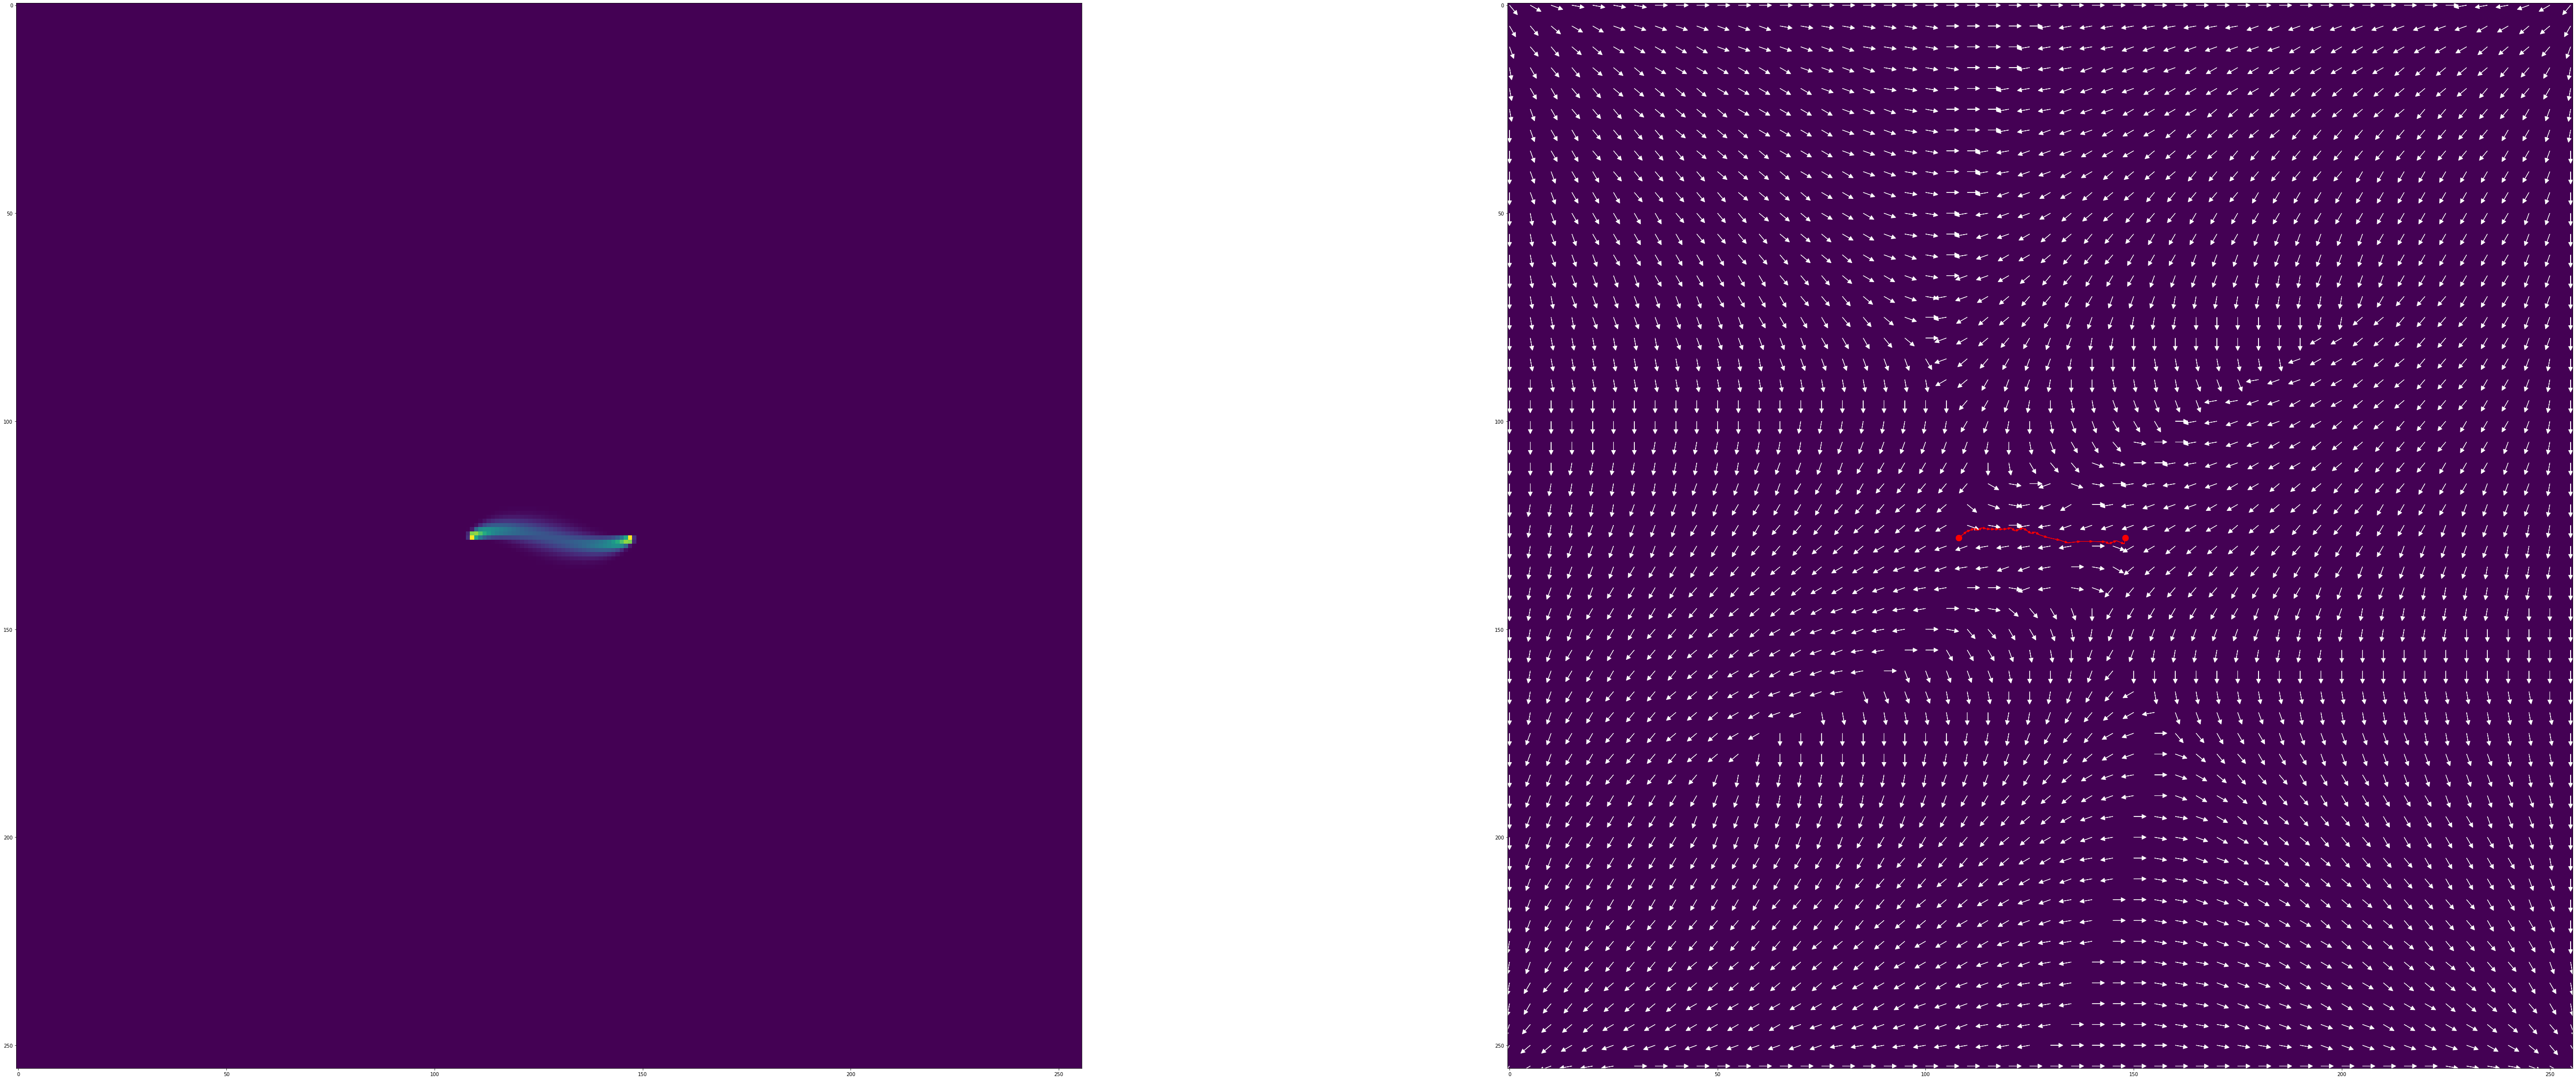

In [18]:
# Creating a sample SCF
keypoints = [{"y": 128, "x": 108, "theta": np.pi / 6}, {"y": 128, "x": 148, "theta": np.pi + np.pi/6}]
tau = 40
diff = 0.01
total_comp_field = cp.zeros((256, 256, 36))
all_comp_fields = []
src_pt = 0
for i in trange(len(keypoints)):
  if i == 0:
    sources = [keypoints[i]]
    sinks = keypoints[i+1:]
  elif i == len(keypoints) - 1:
    sources = [keypoints[i]]
    sinks = keypoints[:-1]
  else:
    sources = [keypoints[i]]
    sinks = keypoints[0:i] + keypoints[i+1:]
  sources, sinks = translate_pointset(sources), translate_pointset(sinks)
  source_field = compute_fokker_planck(sources, tau=tau, sigma_sqrt=cp.sqrt(diff))
  sink_field = compute_fokker_planck(sinks, tau=tau, sigma_sqrt=cp.sqrt(diff), src=False)
  comp_field = cp.multiply(source_field, sink_field)
  all_comp_fields.append(cp.asnumpy(comp_field))
  total_comp_field += comp_field

comp_sum = total_comp_field.sum(axis=2)

# Plotting the SCF
plt.figure(figsize=(100, 40))
scf_vector_field = np.copy(cp.asnumpy(total_comp_field))
plt.subplot(1,2,1)
plt.imshow(np.sum(scf_vector_field, axis=2))


# Plotting the SCF vector field
plt.subplot(1,2,2)
all_paths = []
plt.imshow(np.zeros((256, 256)))
for y in range(0, scf_vector_field.shape[0], 5):
  for x in range(0, scf_vector_field.shape[1], 5):
    draw_arrow(scf_vector_field, x, y)

# Plotting keypoints on top of vector field
for keypoint in keypoints:
  plt.plot([int(keypoint['x']) for keypoint in keypoints], [int(keypoint['y']) for keypoint in keypoints], 'ro', markersize=12, color='red')

# Plotting greedy path on top of the vector field
for i in range(len(keypoints)):
  comp_field = all_comp_fields[i]
  if i == 0:
    source = keypoints[i]
    sinks = keypoints[i+1:]
  elif i == len(keypoints) - 1:
    source = keypoints[i]
    sinks = keypoints[:-1]
  else:
    source = keypoints[i]
    sinks = keypoints[0:i] + keypoints[i+1:]
  path = trace(comp_field, source=source, sinks=sinks)
  if path is not None:
    all_paths.append(path)
  break # Will only plot one traced path, here

for path in all_paths:
  for i in range(len(path) - 1):
    prev_point, curr_point = path[i], path[i+1]
    del_x = curr_point[1] - prev_point[1]
    del_y = curr_point[0] - prev_point[0]
    plt.arrow(prev_point[1], prev_point[0], del_x, del_y, color='red', length_includes_head=True,
    head_width=0.5, head_length=0.7)

plt.show()
